In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from PIL import Image

### For plaidml 
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

### For tensorflow 
# os.environ['KERAS_BACKEND'] = 'tensorflow'
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
# from tensorflow.keras.models import Sequential, model_from_json, load_model
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [14]:
batch_size = 32
DS_DIR = os.path.join(os.getcwd(), 'datasets')
TRAINING_DIR = os.path.join(DS_DIR, 'training_set')
VALID_DIR = os.path.join(DS_DIR, 'valid_set')
AUG_DIR = os.path.join(os.getcwd(), 'augmented_datasets')
MODEL_PATH = os.path.join(os.getcwd(), 'model')
RES_PATH = os.path.join(os.getcwd(), 'results')
# path to model weights and architechture file
MODEL_FILE = os.path.join(MODEL_PATH, 'weights.hdf5')
LOG_DIR = os.path.join(os.getcwd(),
                       "logs/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
print('Dataset Directiry       :', DS_DIR)
print('Training Set Directiry  :', TRAINING_DIR)
print('Validation Set Directiry:', VALID_DIR)
print('Augmented Set Directiry :', AUG_DIR)
print('Trained Model Saved to  :', MODEL_FILE)
print('Training Log Saved to   :', LOG_DIR)
print('Hidden Layer Saved to   :', RES_PATH)

Dataset Directiry       : /home/wei/git/itir_cv/datasets
Training Set Directiry  : /home/wei/git/itir_cv/datasets/training_set
Validation Set Directiry: /home/wei/git/itir_cv/datasets/valid_set
Augmented Set Directiry : /home/wei/git/itir_cv/augmented_datasets
Trained Model Saved to  : /home/wei/git/itir_cv/model/weights.hdf5
Training Log Saved to   : /home/wei/git/itir_cv/logs/20200830_160831
Hidden Layer Saved to   : /home/wei/git/itir_cv/results


In [6]:
training_datagen = ImageDataGenerator(rotation_range=60,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=False,
                                      fill_mode='nearest')

training_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rotation_range=30,
                                        zoom_range=0.2,
                                        fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale')

Found 3558 images belonging to 4 classes.
Found 137 images belonging to 4 classes.


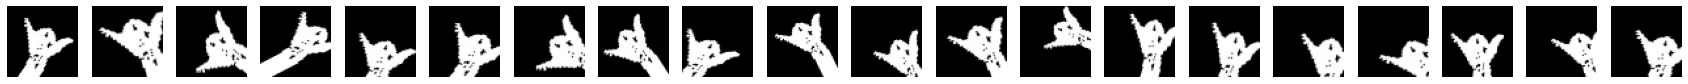

In [7]:
img = load_img(TRAINING_DIR + '/swing/swing_1.jpg', target_size=(54, 54))  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (54, 54, 3)
x = x.reshape((1, ) + x.shape)
# this is a Numpy array with shape (1, 54, 54, 3)

NUM_IMG_SHOW = 20
fig, axes = plt.subplots(1,
                         NUM_IMG_SHOW,
                         sharex=True,
                         figsize=(30, 30 * NUM_IMG_SHOW))

i = 0
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `AUG_DIR/` directory
for batch in training_datagen.flow(x,
                                   batch_size=1,
                                   save_to_dir=AUG_DIR,
                                   save_prefix='aug',
                                   save_format='jpeg'):
    if i < NUM_IMG_SHOW:
        img = array_to_img(batch.squeeze(axis=0))
        axes[i].imshow(img)
        axes[i].set_axis_off()
    else:
        break
    i += 1
plt.show()

In [8]:
 model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])
# model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 54, 54, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
activation_3 (Activation)    (None, 25, 25, 32)        0         
__________

In [9]:
if os.environ['KERAS_BACKEND'] == 'plaidml.keras.backend': 
    early = EarlyStopping(monitor="val_acc", patience=50, verbose=1, mode="auto")
    cb = [early]
else:
    early = EarlyStopping(monitor="accuracy", patience=50, verbose=1, mode="auto")
    tensorboard_callback = TensorBoard(log_dir=LOG_DIR,
                                   histogram_freq=2,
                                   embeddings_freq=2,
                                   write_images=False)    
    cb = [early, tensorboard_callback]

history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=len(training_generator) // batch_size,
    epochs=1000,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // batch_size,
    workers=8,
    callbacks = cb,
)

Epoch 1/1000
3/3 [==============================] - 11s 4s/step - loss: 153.2777 - acc: 0.2812 - val_loss: 86.6279 - val_acc: 0.1314
Epoch 2/1000
3/3 [==============================] - 0s 39ms/step - loss: 29.3879 - acc: 0.3438 - val_loss: 10.0627 - val_acc: 0.2555
Epoch 3/1000
3/3 [==============================] - 0s 88ms/step - loss: 4.3694 - acc: 0.3021 - val_loss: 2.8774 - val_acc: 0.4234
Epoch 4/1000
3/3 [==============================] - 0s 86ms/step - loss: 2.2924 - acc: 0.2604 - val_loss: 1.5071 - val_acc: 0.2847
Epoch 5/1000
3/3 [==============================] - 0s 73ms/step - loss: 1.5470 - acc: 0.3229 - val_loss: 1.3281 - val_acc: 0.3723
Epoch 6/1000
3/3 [==============================] - 0s 83ms/step - loss: 1.5511 - acc: 0.3229 - val_loss: 1.5504 - val_acc: 0.3942
Epoch 7/1000
3/3 [==============================] - 0s 82ms/step - loss: 1.8687 - acc: 0.2500 - val_loss: 1.0699 - val_acc: 0.6204
Epoch 8/1000
3/3 [==============================] - 0s 81ms/step - loss: 1.3640

3/3 [==============================] - 0s 79ms/step - loss: 0.5778 - acc: 0.7917 - val_loss: 0.4066 - val_acc: 0.8394
Epoch 64/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.7622 - acc: 0.7188 - val_loss: 0.3869 - val_acc: 0.8832
Epoch 65/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.5668 - acc: 0.7917 - val_loss: 0.4125 - val_acc: 0.8686
Epoch 66/1000
3/3 [==============================] - 0s 73ms/step - loss: 0.8732 - acc: 0.7188 - val_loss: 0.3605 - val_acc: 0.8540
Epoch 67/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.6900 - acc: 0.7396 - val_loss: 0.5113 - val_acc: 0.7883
Epoch 68/1000
3/3 [==============================] - 0s 67ms/step - loss: 0.4579 - acc: 0.7917 - val_loss: 0.6610 - val_acc: 0.7737
Epoch 69/1000
3/3 [==============================] - 0s 84ms/step - loss: 0.5912 - acc: 0.8229 - val_loss: 0.4870 - val_acc: 0.8248
Epoch 70/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.5883 - acc: 0.

Epoch 125/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.4181 - acc: 0.8854 - val_loss: 0.2244 - val_acc: 0.9197
Epoch 126/1000
3/3 [==============================] - 0s 70ms/step - loss: 0.3680 - acc: 0.8958 - val_loss: 0.3667 - val_acc: 0.8686
Epoch 127/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.3672 - acc: 0.8542 - val_loss: 0.2084 - val_acc: 0.9270
Epoch 128/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.3521 - acc: 0.8854 - val_loss: 0.1870 - val_acc: 0.9416
Epoch 129/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.3085 - acc: 0.8854 - val_loss: 0.3415 - val_acc: 0.8832
Epoch 130/1000
3/3 [==============================] - 0s 86ms/step - loss: 0.3030 - acc: 0.8412 - val_loss: 0.2337 - val_acc: 0.8686
Epoch 131/1000
3/3 [==============================] - 0s 81ms/step - loss: 0.3611 - acc: 0.8854 - val_loss: 1.4629 - val_acc: 0.5474
Epoch 132/1000
3/3 [==============================] - 0s 90ms/step - 

3/3 [==============================] - 0s 63ms/step - loss: 0.4321 - acc: 0.8854 - val_loss: 0.1761 - val_acc: 0.9562
Epoch 187/1000
3/3 [==============================] - 1s 174ms/step - loss: 0.2288 - acc: 0.9167 - val_loss: 0.3249 - val_acc: 0.8832
Epoch 188/1000
3/3 [==============================] - 0s 90ms/step - loss: 0.2608 - acc: 0.9479 - val_loss: 0.6572 - val_acc: 0.7883
Epoch 189/1000
3/3 [==============================] - 0s 80ms/step - loss: 0.4384 - acc: 0.8646 - val_loss: 0.1624 - val_acc: 0.9343
Epoch 190/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.4785 - acc: 0.8646 - val_loss: 0.2247 - val_acc: 0.9270
Epoch 191/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.3811 - acc: 0.9271 - val_loss: 0.1358 - val_acc: 0.9635
Epoch 192/1000
3/3 [==============================] - 0s 76ms/step - loss: 0.2867 - acc: 0.9167 - val_loss: 0.4566 - val_acc: 0.8321
Epoch 193/1000
3/3 [==============================] - 0s 81ms/step - loss: 0.3739 -

Epoch 248/1000
3/3 [==============================] - 0s 87ms/step - loss: 0.2768 - acc: 0.8854 - val_loss: 0.2338 - val_acc: 0.9197
Epoch 249/1000
3/3 [==============================] - 0s 81ms/step - loss: 0.2023 - acc: 0.9479 - val_loss: 0.6175 - val_acc: 0.8248
Epoch 250/1000
3/3 [==============================] - 0s 89ms/step - loss: 0.2950 - acc: 0.8854 - val_loss: 0.1691 - val_acc: 0.9343
Epoch 251/1000
3/3 [==============================] - 0s 93ms/step - loss: 0.2560 - acc: 0.9271 - val_loss: 0.3330 - val_acc: 0.9124
Epoch 252/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.3231 - acc: 0.8854 - val_loss: 0.3845 - val_acc: 0.8905
Epoch 253/1000
3/3 [==============================] - 0s 85ms/step - loss: 0.3182 - acc: 0.9271 - val_loss: 0.1626 - val_acc: 0.9416
Epoch 254/1000
3/3 [==============================] - 0s 79ms/step - loss: 0.2430 - acc: 0.8854 - val_loss: 0.1688 - val_acc: 0.9416
Epoch 255/1000
3/3 [==============================] - 0s 92ms/step - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


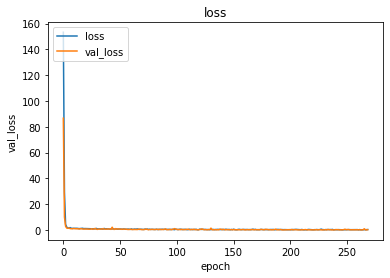

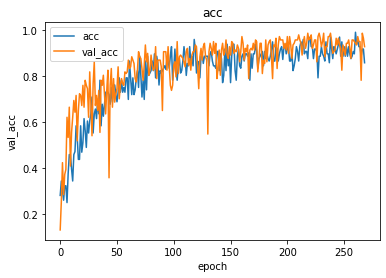

In [10]:
print(history.history.keys())
if  os.environ['KERAS_BACKEND'] == 'plaidml.keras.backend': 
    loss_key = ['loss', 'val_loss']
    acc_key = ['acc', 'val_acc']
else:
    loss_key = ['loss']
    acc_key = ['accuracy']
for k in loss_key:
    plt.plot(history.history[k])
plt.title('loss')
plt.ylabel(k)
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

for k in acc_key:
    plt.plot(history.history[k])
plt.title('acc')
plt.ylabel(k)
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')

plt.show()

List of all layers in this model  ['conv2d_1', 'activation_1', 'conv2d_2', 'activation_2', 'max_pooling2d_1', 'conv2d_3', 'activation_3', 'conv2d_4', 'activation_4', 'max_pooling2d_2', 'flatten_1', 'dense_1', 'activation_5', 'dense_2', 'activation_6']
Visualizing layer 0  with name  conv2d_1
Visualizing layer 2  with name  conv2d_2
Visualizing layer 5  with name  conv2d_3
Visualizing layer 7  with name  conv2d_4
Visualizing layer 8  with name  activation_4
List of all layers in this model  ['conv2d_1', 'activation_1', 'conv2d_2', 'activation_2', 'max_pooling2d_1', 'conv2d_3', 'activation_3', 'conv2d_4', 'activation_4', 'max_pooling2d_2', 'flatten_1', 'dense_1', 'activation_5', 'dense_2', 'activation_6']
Visualizing layer 0  with name  conv2d_1
Visualizing layer 2  with name  conv2d_2
Visualizing layer 5  with name  conv2d_3
Visualizing layer 7  with name  conv2d_4
Visualizing layer 8  with name  activation_4
List of all layers in this model  ['conv2d_1', 'activation_1', 'conv2d_2', 'ac

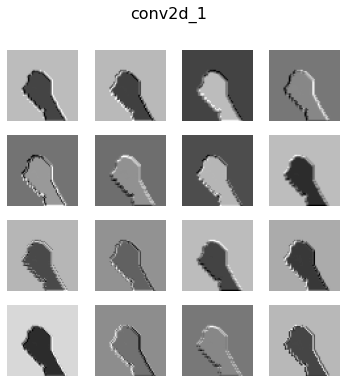

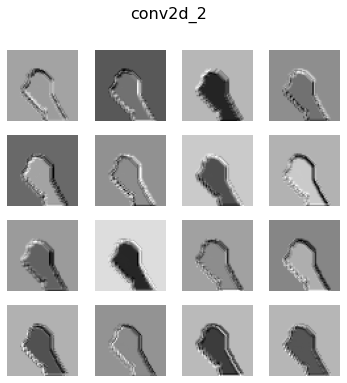

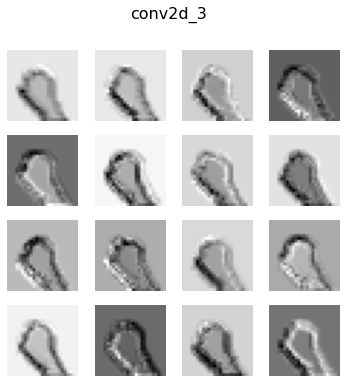

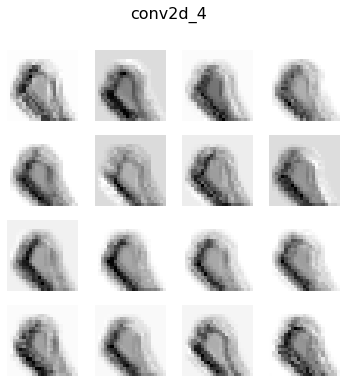

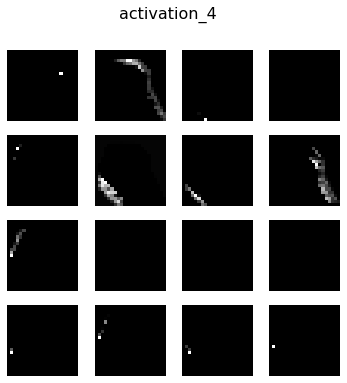

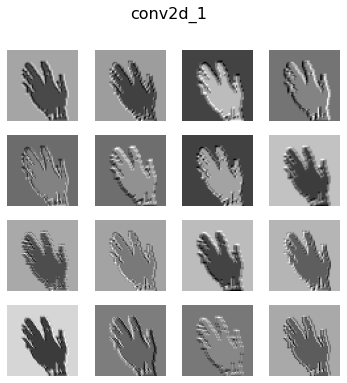

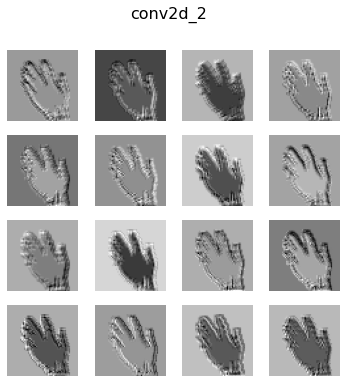

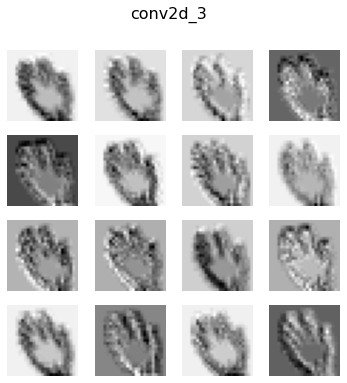

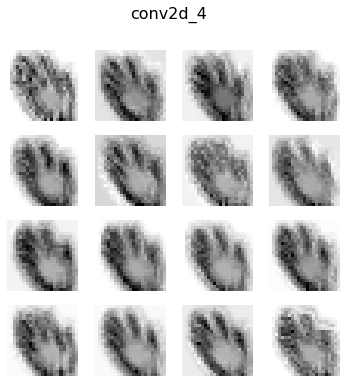

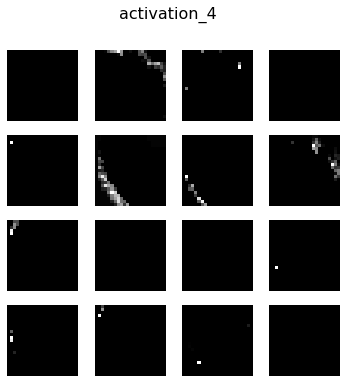

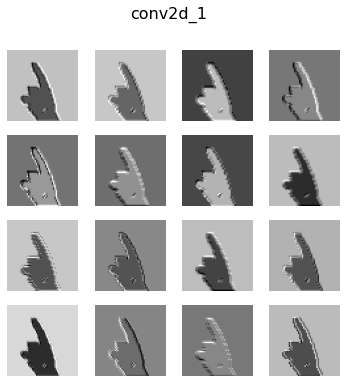

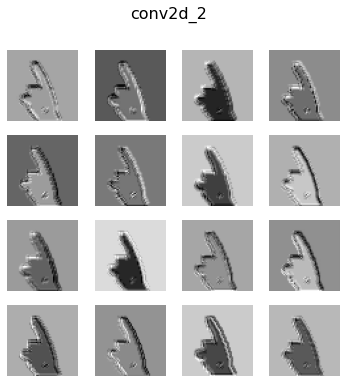

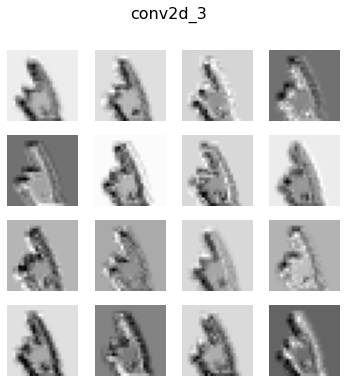

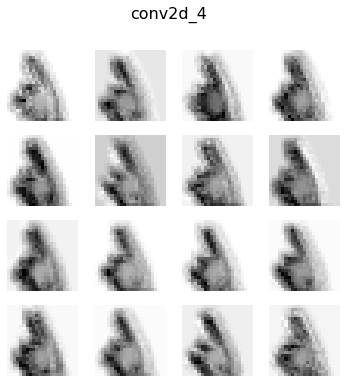

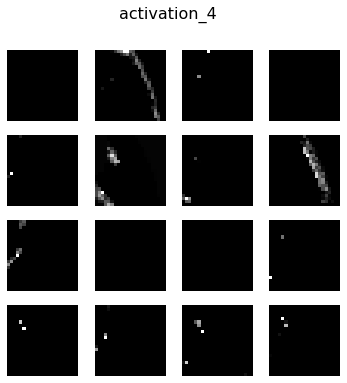

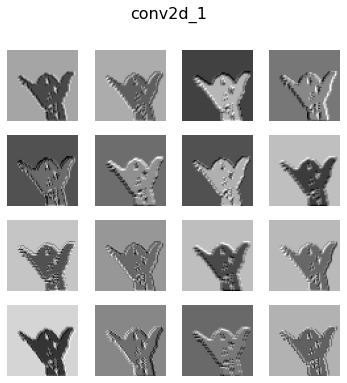

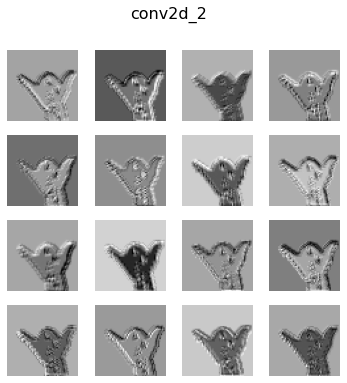

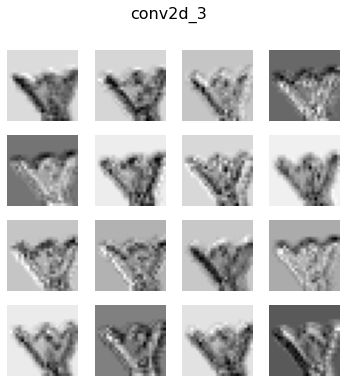

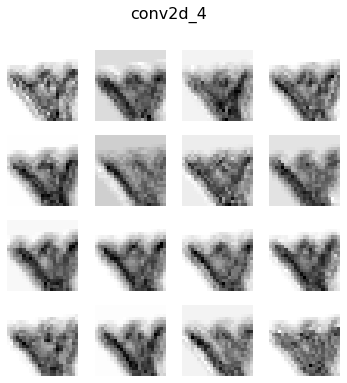

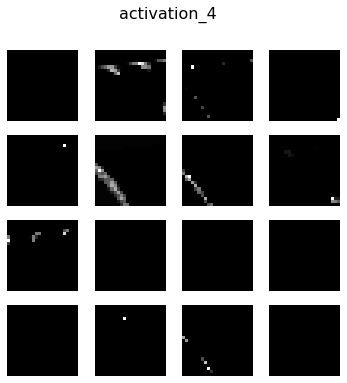

In [17]:
def plot_activation(activations, col_size, row_size, act_index, layer_names):
    activation = activations[act_index]
    activation_index = 0
    fig, ax = plt.subplots(row_size,
                           col_size,
                           sharex=True,
                           sharey=True,
                           figsize=(row_size * 1.5, col_size * 1.5))

    wanted_layer_idx = wanted_layer_idxs[act_index]
    fig.suptitle(layer_names[wanted_layer_idx], fontsize=16)

    for row in range(0, row_size):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index],
                                cmap='gray')
            ax[row][col].set_axis_off()
            activation_index += 1
    return fig


classes = {0: 'fist', 1: 'five', 2: 'point', 3: 'swing'}
for (key, gest) in classes.items():  # Iterate through a list of gestures
    test_img = os.path.join(TRAINING_DIR, gest, gest + '_1.jpg')
    img = load_img(test_img, color_mode="grayscale", target_size=(54, 54))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  #(1, 54, 54, 1)

    wanted_layer_idxs = [0, 2, 5, 7, 8]
    layer_outputs = [model.layers[idx].output for idx in wanted_layer_idxs]
    layer_names = [layer.name for layer in model.layers]
    print('List of all layers in this model ', layer_names)
    for i in wanted_layer_idxs:
        print('Visualizing layer', i, ' with name ', layer_names[i])

    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img)

    for idx, val in enumerate(wanted_layer_idxs):
        g = plot_activation(activations, 4, 4, idx, layer_names)
        path = os.path.join(RES_PATH, 'hidden_layer',
                            gest + '_' + layer_names[idx])
        g.savefig(path, facecolor='white')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=LOG_DIR+'/..' --host localhost

In [ ]:
while True:
    ans = input('Do you want to save this model ? Yy/Nn')
    if ans == 'Y' or ans == 'y':
        model.save(MODEL_FILE)
        print('Model saved to ', MODEL_FILE)
        break
    elif ans == 'N' or ans == 'n':
        print('Exit without saving this model')
        break
    else:
        print('Cannot recognize input ', ans)